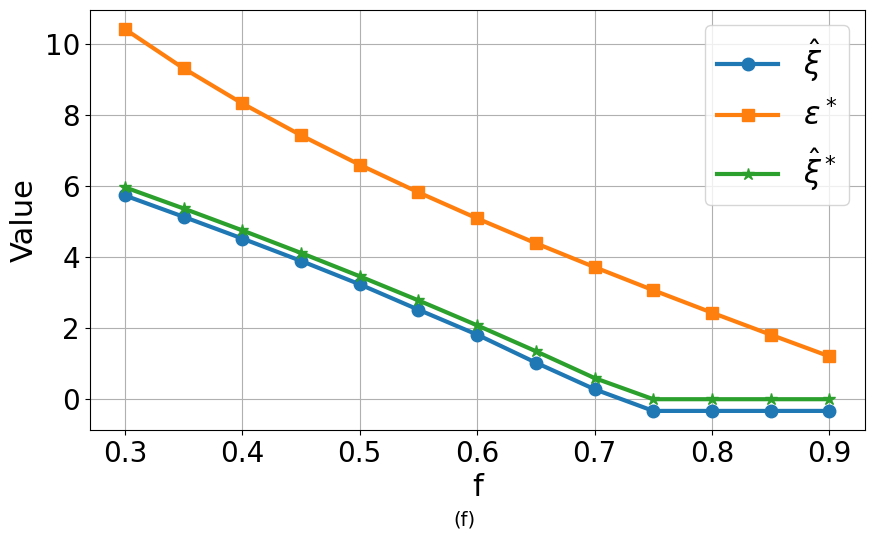

In [43]:
import numpy as np
import mmh3
import scipy.stats as stats
from joblib import Parallel, delayed
import matplotlib.pyplot as plt
from statsmodels.distributions.empirical_distribution import ECDF
from scipy.interpolate import interp1d
from scipy.optimize import root_scalar
from scipy.stats import laplace, norm
import matplotlib.pyplot as plt
import math
import itertools
from collections import Counter



def hyp_distance_max(scal_par):
    m_1 = 2
    m_2 = 1
    out = scal_par * (max(m_1, m_2) - min(m_1, m_2)) + np.log(2 - np.exp(
        -scal_par * max(m_1, m_2))) - np.log(2 -
                                             np.exp(-scal_par * min(m_1, m_2)))
    return out



def inverse(f, lower=-100, upper=100):

    def func(y):
        return root_scalar(lambda x: f(x) - y, bracket=[lower, upper]).root

    return func


hyp_inverse = inverse(hyp_distance_max, 0, 10)


class ZeroNoisePrng:
    """
    A dummy PRNG returning zeros always.
    """

    def laplace(self, *args, size=1, **kwargs):
        return np.zeros(shape=size)

    def exponential(self, *args, size=1, **kwargs):
        return np.zeros(shape=size)

    def binomial(self, *args, size=1, **kwargs):
        return np.zeros(shape=size)

        
class Rappor():
    """
    Steps 1--3 from:
        Ulfar Erlingsson, Vasyl Pihur, and Aleksandra Korolova. 2014.
        RAPPOR: Randomized Aggregatable Privacy-Preserving Ordinal Response. CCS 2014.
    """

    def __init__(self, n_hashes: int = 2, filter_size: int = 6, f: float = 0.8, p: float = 0.45, q: float = 0.55, prng=None):
        self.f = f
        self.q = q
        self.p = p
        self.n_hashes = n_hashes
        self.filter_size = filter_size

        if prng is None:
            self.prng = np.random.default_rng()
        else:
            self.prng = prng

    def m(self, a, n_samples: int = 1):
        assert (a.shape == (1,) or a.shape == ())
        val = a.item(0)

        # populate bloom filter
        filter = self._populate_bloom_filter(val, n_samples)

        if isinstance(self.prng, ZeroNoisePrng):
            # don't perform any randomization
            return filter

        # permanent randomized response
        self._apply_permanent_randomized_response(filter)

        # instantaneous randomized response
        res = self._get_instantaneous_randomized_response(filter)
        return res

    def _populate_bloom_filter(self, val, n_samples):
        filter = np.zeros((n_samples, self.filter_size))
        for i in range(0, self.n_hashes):
            hashval = mmh3.hash(str(val), seed=i) % self.filter_size
            filter[:, hashval] = 1
        return filter

    def _apply_permanent_randomized_response(self, filter):
        choices = np.random.choice(3, size=filter.shape, p=[0.5*self.f, 0.5*self.f, 1-self.f])
        filter[choices == 0] = 1
        filter[choices == 1] = 0

    def _get_instantaneous_randomized_response(self, filter):
        res = np.zeros(shape=filter.shape)
        set_to_1_q = np.logical_and(filter == 1, self.prng.binomial(n=1, p=self.q, size=filter.shape) == 1)
        set_to_1_p = np.logical_and(filter == 0, self.prng.binomial(n=1, p=self.p, size=filter.shape) == 1)
        res[set_to_1_p] = 1
        res[set_to_1_q] = 1
        return res


class OneTimeRappor(Rappor):
    """
    Steps 1--2 from:
        Ulfar Erlingsson, Vasyl Pihur, and Aleksandra Korolova. 2014.
        RAPPOR: Randomized Aggregatable Privacy-Preserving Ordinal Response. CCS 2014.
    """
    def __init__(self, n_hashes: int = 3, filter_size: int =6, f: float = 0.8, prng=None):
        super().__init__(n_hashes=n_hashes, filter_size=filter_size, f=f, prng=prng)

    def m(self, a, n_samples=1):
        # assert (a.shape == (1,) or a.shape == ())
        # val = a.item(0)

        # populate bloom filter
        # filter = self._populate_bloom_filter(val, n_samples)
        # generate data based on filter_size
        if a==0:
            filter=np.tile(np.array([1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]),(n_samples,1))

        if a==1:
            filter=np.tile(np.array([0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]),(n_samples,1))

        if a==2:
            filter=np.tile(np.array([1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]),(n_samples,1))

        if a==3:
            filter=np.tile(np.array([0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0]),(n_samples,1))

        if isinstance(self.prng, ZeroNoisePrng):
            # don't perform any randomization
            return filter

        # permanent randomized response
        self._apply_permanent_randomized_response(filter)
        

        return filter

def binary_vector_to_decimal(binary_vector):
    # binary to string
    binary_str = ''.join(map(str, binary_vector))
    
    # string to decimal
    decimal_number = int(binary_str, 2)
    
    return decimal_number


B=4
def MPL(eps, sens, n, N, alpha, delta,filter_size):
    epsilon_max = -1
    t_max = np.array([])
    x1_max = np.array([])
    x2_max = np.array([])
    
    for i in range(B):
        qu_1=0
        result_1 = privacy_mechanism.m(a=qu_1,n_samples=n)
        qu_2=i
        result_2 = privacy_mechanism.m(a=qu_2, n_samples=n)
        


        dens_1 = np.zeros(2**filter_size)
        for v in result_1:
            v_int=list(map(int,v))
            dens_1[binary_vector_to_decimal(v_int)] = dens_1[binary_vector_to_decimal(v_int)] + 1

        dens_1=dens_1/n

        dens_2 = np.zeros(2**filter_size)
        for v in result_2:
            v_int=list(map(int,v))
            dens_2[binary_vector_to_decimal(v_int)] = dens_2[binary_vector_to_decimal(v_int)] + 1

        dens_2=dens_2/n
    
    
        # Compute loss function with floor and determine maximum loss
        loss_hat = np.abs(np.log(np.maximum(delta, dens_1)) - np.log(np.maximum(delta, dens_2)))

        epsilon_hat = max(loss_hat)
        t_hat = np.argmax(loss_hat)
        
        # Record data bases and location associated with the current maximum loss
        if epsilon_hat > epsilon_max:
            epsilon_max = epsilon_hat
            t_max = t_hat
            x1_max = qu_1
            x2_max = qu_2

    result_3 = privacy_mechanism.m(x1_max, N)
    dens_3 = np.zeros(2**filter_size)
    for v in result_3:
        v_int=list(map(int,v))
        dens_3[binary_vector_to_decimal(v_int)] = dens_3[binary_vector_to_decimal(v_int)] + 1

    dens_3=dens_3/N

      
   
    f_star_1 = max(dens_3[t_max], delta)

    # Recompute Maximum Loss and Statistic on larger sample sizes

    result_4 =privacy_mechanism.m(x2_max, N)
    dens_4= np.zeros(2**filter_size)
    for v in result_4:
        v_int=list(map(int,v))
        dens_4[binary_vector_to_decimal(v_int)] = dens_4[binary_vector_to_decimal(v_int)] + 1

    dens_4=dens_4/N

       
    f_star_2 = max(dens_4[t_max], delta)

    sigma_hat = (1 / f_star_1 + 1 / f_star_2) - 2
    loss_star = np.abs(np.log(f_star_1) - np.log(f_star_2))
   
    LB = loss_star + (stats.norm.ppf(alpha) * np.sqrt(sigma_hat)) / np.sqrt(N)

    return LB

def calculate_MPL( eps, sens, n, N, alpha, delta, filter_size):
    return MPL(eps, sens, n, N, alpha, delta, filter_size)


eps = 25.62
sens = 1
n = 200000
N = 500000
alpha = 0.05
delta = 0.0001
tune = 0.15
filter_size=20 # modify filter_size



f_values = np.arange(0.3, 0.95, 0.05)
epslion_star = np.zeros_like(f_values)
xi_hat = np.zeros_like(f_values)
xi_star_hat = np.zeros_like(f_values)

for i, f in enumerate(f_values):
    epslion_star[i] = math.log(((1-0.5*f)/(0.5*f))**6)
    xi_star_hat[i] = min(epslion_star[i], math.log(max(((1-0.5*f)**filter_size), delta)/delta))
    privacy_mechanism = OneTimeRappor(n_hashes=3, filter_size=20, f=f)  # modify filter_size
    reps = 5
    A = Parallel(n_jobs=7)(delayed(calculate_MPL)(eps, sens, n, N, alpha, delta, filter_size) for _ in range(reps))
    final_array = np.array(A)
    xi_hat[i] = sum(final_array) / len(final_array)

plt.figure(figsize=(10, 6))
plt.subplots_adjust(bottom=0.18)

# print the first line
plt.plot(f_values, xi_hat, marker='o', markersize=9,linewidth=3,label=r'$\hat{\xi}$')

# print the second line
plt.plot(f_values, epslion_star, marker='s',markersize=9, linewidth=3,label=r'$\epsilon^*$')

# print the third line
plt.plot(f_values, xi_star_hat, marker='*', markersize=9,linewidth=3,label=r'$\hat{\xi}^*$')


plt.xlabel('f', fontsize=22)
plt.ylabel('Value', fontsize=22)
plt.xticks(fontsize=20)  
plt.yticks(fontsize=20)  
plt.legend(fontsize=22)
plt.grid(True)

# gcf: Get Current Figure
fig=plt.gcf()
fig.text(0.5, 0.02, '(f)', ha='center', fontsize=14)



